In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from MiningMinima import *
from calc_hessian_at_min import *
from minimization import *
import numpy as np
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

PyRosetta-4 2019 [Rosetta PyRosetta4.Release.python27.ubuntu 2019.33+release.1e60c63beb532fd475f0f704d68d462b8af2a977 2019-08-09T15:19:57] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
core.init: Checking for fconfig files in pwd and ./rosetta/flags
core.init: Rosetta version: PyRosetta4.Release.python27.ubuntu r230 2019.33+release.1e60c63beb5 1e60c63beb532fd475f0f704d68d462b8af2a977 http://www.pyrosetta.org 2019-08-09T15:19:57
core.init: command: PyRosetta -ex1 -ex2aro -database /usr/local/lib/python2.7/dist-packages/pyrosetta-2019.33+release.1e60c63beb5-py2.7-linux-x86_64.egg/pyrosetta/database
basic.random.init_random_generator: 'RNG device' seed mode, using '/dev/urandom', seed=-1399000646 seed_offset=0 real_seed=-1399000646
basic.random.init_random_generator: RandomGenerator:init: Normal mode, seed=-1399000646 RG_type=mt19937


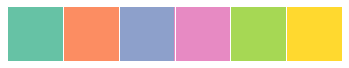

In [2]:
sns.set()
palette = 'Set2'
sns.palplot(sns.color_palette(palette))
sns.set_palette(sns.color_palette(palette))
sns.set_style('whitegrid')
sns.set_context('talk')

### Some useful parameters for later on

fa_atr                      0.69
fa_rep                      0.11
fa_intra_rep                0.0068
rna_torsion                 6.13
hbond_sc                    2.99
fa_sol                      0
lk_ball		                0.68
stack_elec                  2.29
fa_elec_rna_phos_phos       9.53

In [4]:
limit = np.pi/3
dx = 0.005
F = np.linspace(-100, 800, 9001)
dF = 0.1
rna_min_based = [0.69,0.11,0.0068,6.13,2.99,0,0.68,2.29,9.53]

In [5]:
from recces.data import _get_duplex_seqs
from recces.util import DG_CANONICAL, DG_DANGLING

In [5]:
pos, neg = _get_duplex_seqs('ga', 'uc')

In [6]:
print(pos,neg)

(('gga_ucc', 'gg', 'cc'), ('gg_cc', 'gga', 'ucc'))


In [9]:
def dg_mm(seq1, seq2):
    # get relevant simulations
    pos, neg = _get_duplex_seqs(seq1, seq2)

    dG = 0.

    for ii, sim in enumerate(pos):
        if ii == 0:
            dG += sim_dict[sim].anharmonic_free_energy - 0.5*np.log(2*np.pi/3)*sim_dict[sim].n_dofs
        else:
            dG += SingleSimulation('/scratch/users/maa805/recces_rosetta/results/rna_min/{}/ST/'.format(sim), rna_min_based).value

    for ii, sim in enumerate(neg):
        if ii == 0: 
            dG -= sim_dict[sim].anharmonic_free_energy - 0.5*np.log(2*np.pi/3)*sim_dict[sim].n_dofs
        else: 
            dG -= SingleSimulation('/scratch/users/maa805/recces_rosetta/results/rna_min/{}/ST/'.format(sim), rna_min_based).value

    return dG

In [16]:
del fuck_dict

In [17]:
fuck_dict = {}
for key in DG_CANONICAL.iterkeys():
    seq1, seq2 = key
    fuck_dict[key] = dg_mm(seq1, seq2)*KT_IN_KCAL


Inferring sequence from directory name:  gc
Created:  hist_list.txt
applying phase space volume for single strand with length  2
Inferring sequence from directory name:  gc
Created:  hist_list.txt
applying phase space volume for single strand with length  2
Inferring sequence from directory name:  gcg
Created:  hist_list.txt
applying phase space volume for single strand with length  3
Inferring sequence from directory name:  cgc
Created:  hist_list.txt
applying phase space volume for single strand with length  3
Inferring sequence from directory name:  gc
Created:  hist_list.txt
applying phase space volume for single strand with length  2
Inferring sequence from directory name:  gc
Created:  hist_list.txt
applying phase space volume for single strand with length  2
Inferring sequence from directory name:  gcc
Created:  hist_list.txt
applying phase space volume for single strand with length  3
Inferring sequence from directory name:  ggc
Created:  hist_list.txt
applying phase space volu

In [18]:
recces_vals = []
mm_vals = []

for key in fuck_dict.iterkeys():
    mm_vals.append(fuck_dict[key]*KT_IN_KCAL)
    recces_vals.append(DG_CANONICAL[key])
    
recces_vals = np.array(recces_vals)
mm_vals = np.array(mm_vals)

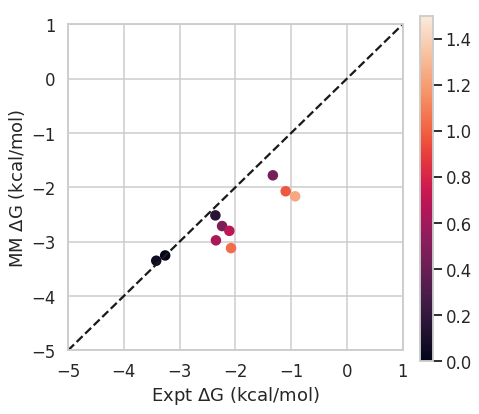

In [21]:
norm = plt.Normalize(0,1.5)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
sc = ax.scatter(recces_vals, mm_vals, c=np.abs(recces_vals-mm_vals), norm=norm)
ax.plot([-5, 1],[-5,1], 'k--')
ax.set_xlim((-5,1))
ax.set_ylim((-5,1))
ax.set_xlabel('Expt $\Delta$G (kcal/mol)')
ax.set_ylabel('MM $\Delta$G (kcal/mol)')
cbaxes = fig.add_axes([0.94, 0.1, 0.03, 0.8]) 
fig.colorbar(sc, cax=cbaxes)
plt.show()

In [22]:
np.sqrt(np.mean((recces_vals-mm_vals)**2))

0.699526822715701

In [ ]:
print recces_vals - mm_vals

In [7]:
from recces.data import SingleHistSimulation, SingleSimulation

def calculate_anharmonicitiy(mm_sim):
    w = list([])
    h = np.linspace(-limit, limit, int(2*limit/dx)+1)
    dh = h[1]-h[0]
    
    mode_scans = mm_sim.mode_scans
    eigenvalues = mm_sim.eigenvalues
    for ii in range(mm_sim.n_dofs):
        w_anharmonic = np.trapz(h**2*np.exp(-mode_scans[ii]), dx=h[1]-h[0])/np.trapz(np.exp(-mode_scans[ii]), dx=dh)
        w_harmonic = np.trapz(np.exp(-0.5*eigenvalues[ii]*h**2)*h**2,dx=h[1]-h[0])/np.trapz(np.exp(-0.5*eigenvalues[ii]*h**2), dx=h[1]-h[0])
        w.append(w_anharmonic/w_harmonic)

    return w

In [9]:
from scipy.special import logsumexp
limit = np.pi/3
dx = 0.005
F = np.linspace(-100,800,9001)
dF = 0.1

sims = ['gaa_uuc', 'gac_guc', 'gag_cuc', 'gau_auc', 
        'gca_ugc', 'gcc_ggc', 'gcg_cgc', 'gcu_agc',
        'gga_ucc', 'ggc_gcc', 'ggg_ccc', 'ggu_acc',
        'gua_uac', 'guc_gac', 'gug_cac', 'guu_aac',
        'ga_uc', 'gc_gc', 'gg_cc', 'gu_ac']
F = np.linspace(-100,800,9001)
dF = 0.1
anharmonic_E = []
#harmonic_E = []
RECCES_E = []
DOS_E = []
recces_dict = {}
sim_dict = {}

E = np.linspace(-100,800,9001)

for sim in sims:
    print sim
    seqs = sim.split('_')
    seq1 = seqs[0]
    seq2 = seqs[1]
    
    fuck = MiningMinima(seq1, seq2, scorefxn='rna_min_based_turner.wts')
    sim_dict[sim] = fuck
    #hist = SingleSimulation('/scratch/users/maa805/recces_rosetta/results/rna_min//'+sim+'/ST/', rna_min_based)
    
    anharmonic_E.append(fuck.min_energy - fuck.total_log_partition )#- np.log(2*limit)*0.5*fuck.n_dofs + 0*len(seq1)*np.log(2*np.pi/3))
        
    #RECCES_E.append(hist.value)
    DOS_E.append(-logsumexp(-F,b=fuck.dos(F)*dF) + np.log(dF))# - np.log(2*limit)*1.0*fuck.n_dofs + 0*np.log(2*np.pi/3)*len(seq1)) 
    print fuck.eigenvalues
    print sim, anharmonic_E[-1], DOS_E[-1], #RECCES_E[-1]
    #w_dict[sim] = calculate_anharmonicitiy(fuck)

 gaa_uuc
-64.12116430897395
1e+99
-64.12116626933054
1.960356598829094e-06
-64.12116705332355
7.839930020736574e-07
-64.12116749599971
4.426761677223112e-07
-64.12116883424638
1.3382466619304978e-06
-64.12116884032753
6.081151582293387e-09
-64.12116884203817
1.7106458471971564e-09
-64.12116884313755
1.0993801424774574e-09
Minimization complete
[3.95034520e+00 1.13856821e+01 2.92472687e+01 3.39251001e+01
 3.87307882e+01 4.41854375e+01 4.95248984e+01 7.21305102e+01
 1.12136020e+02 1.18719387e+02 1.30159855e+02 1.41744254e+02
 1.58828434e+02 1.79289528e+02 3.36450110e+02 3.65593980e+02
 4.05552111e+02 4.29457319e+02 6.39834691e+02 9.98867449e+02
 1.22594469e+03 1.65213899e+03 3.05484836e+03 4.84285306e+03
 1.13455428e+04 1.52769241e+04]
gaa_uuc -18.10021609633118 -18.783383090628153 gac_guc
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 3.8147e-08 Deriv= -2.46227e-06 Finite Diff= 0.000307709
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 3.8147e-08 Deriv= -

KeyboardInterrupt: 

In [7]:
print fuck.anharmonic_free_energy

-18.10021609633118


In [ ]:
def recompute_hessian(mm_sim, h):
    mm_sim.hessian = hessian_at_min(mm_sim.min_dofs, mm_sim.multifunc)
    for ii, node in enumerate(mm_sim.min_map.dof_nodes()):
        mm_sim.hessian[ii] *= mm_sim.min_map.torsion_scale_factor(node)
    mm_sim.eigenvalues, mm_sim.modes = np.linalg.eigh(mm_sim.hessian)
    mm_sim.calc_anharmonic_free_energy()
    return mm_sim

In [ ]:
mm_sim = sim_dict['gac_guc']
recompute_hessian(mm_sim, h=1.5e-7)

In [ ]:
mm_sim.anharmonic_free_energy - mm_sim.n_dofs*np.log(2*np.pi/3)*0.5

In [ ]:
sim_dict['gaa_uuc'].anharmonic_free_energy- 0.5*np.log(2*np.pi/3)*sim_dict['gaa_uuc'].n_dofs

In [ ]:
for key in sim_dict.iterkeys():
    seq1, se2 = key.split('_')
    sim = SingleSimulation('/scratch/users/maa805/recces_rosetta/results/rna_min/'+key+'/ST/',rna_min_based)
    print key, sim_dict[key].anharmonic_free_energy - 0.5*np.log(2*np.pi/3)*sim_dict[key].n_dofs, sim.value


In [1]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
norm = plt.Normalize(0,3.5)

harm = np.array(DOS_E)*KT_IN_KCAL
recces = np.array(RECCES_E)*KT_IN_KCAL
anharm = np.array(anharmonic_E)*KT_IN_KCAL

sc = ax[0].scatter(recces, anharm, c=np.abs(recces-anharm), norm=norm)
ax[1].scatter(recces, harm, c=np.abs(recces-harm), norm=norm)
for axis in ax:
    axis.set(xlim=(-30, -5), ylim=(-30, -5))
    axis.plot([-30,-5],[-30,-5], 'k--')

cbaxes = fig.add_axes([0.94, 0.1, 0.03, 0.8]) 
fig.colorbar(sc, cax=cbaxes)
fig.text(0.5, 0.04, 'RECCES free energy (kcal/mol)', ha='center', va='center')
fig.text(0.06, 0.5, 'estimated free energy (kcal/mol)', ha='center', va='center', rotation='vertical')
print np.sqrt(np.mean((recces-anharm)**2))
print np.sqrt(np.mean((recces-harm)**2))

fig.savefig('/mnt/c/Users/maadr/OneDrive/das-lab/flash-slides/20190927/mm_rna_min_e5')


NameError: name 'plt' is not defined

In [ ]:
dE = []
for ii, val in enumerate(harm):
    if np.isnan(val):
        continue
    else:
        dE.append(val - recces[ii])
print np.sqrt(np.mean(np.array(dE)**2))        

### Developing subroutine to extract gradient evaluations

In [ ]:
# use mm object to get stuff 
seq1, seq2 = 'ggc', 'gcc'
mm_sim = MiningMinima(seq1=seq1, seq2=seq2, scorefxn='stepwise/rna/rna_min_based_turner')

In [ ]:
print mm_sim.eigenvalues

In [ ]:
print mm_sim.min_energy - mm_sim.total_log_partition #- 0.5*np.log(2*np.pi/3)*mm_sim.n_dofs
mm_sim.calc_harmonic_free_energy()
print mm_sim.harmonic_free_energy

In [ ]:
# get pose and scorefxn 
#pose = protocols.recces.pose_setup_turner(seq1=seq1, seq2=seq2)
scorefxn = mm_sim.scorefxn
# set up movemap -- for now just get from the MM object -- and min map
movemap = MoveMap()
movemap.assign(mm_sim.movemap)  
min_map = core.optimization.MinimizerMap()
min_map.setup(pose, movemap)
n = min_map.nangles()

# set up min options
min_options = core.optimization.MinimizerOptions(
    'lbfgs_armijo_nonmonotone_atol', 1.5e-9, True, False, False)
min_options.nblist_auto_update(True)
min_options.max_iter(10000)
# get scorefunction ready for minimization
start_score = scorefxn(pose)
pose.energies().set_use_nblist(pose,min_map.domain_map(), True)
multifunc = core.optimization.AtomTreeMultifunc(pose, min_map, scorefxn)
scorefxn.setup_for_minimizing(pose, min_map) # this is the key command
scorefxn.setup_for_derivatives(pose)

min_dofs = Vector1([0.0]*min_map.nangles())
min_map.copy_dofs_from_pose(pose,min_dofs)
start_func_val = multifunc(min_dofs)
theta = Vector1(list(min_dofs))
dE_dtheta = Vector1(list(min_dofs))
multifunc.dfunc(theta,dE_dtheta)

# set up minimizer and run
minimizer = core.optimization.Minimizer(multifunc, min_options)
for _ in range(1): minimizer.run(min_dofs)
print dE_dtheta

In [ ]:
multifunc(min_dofs)

In [ ]:
E = multifunc(min_dofs)
multifunc.dfunc(min_dofs, dE_dtheta)

eps = 1.5e-5
numerical_derivs = []
for i in range(mm_sim.n_dofs):
    x_pert = Vector1(list(min_dofs))
    x_pert[i+1] += eps
    E_pert = multifunc(x_pert)
    numerical_derivs.append((E_pert-E)/eps)
    print dE_dtheta[i+1], numerical_derivs[-1]


# Developing subroutine to calculate hessian from derivative evaluations

In [ ]:
min_map.copy_dofs_to_pose(pose, min_dofs)
print min_dofs
for key in mm_sim.dof_dict.iterkeys():
    print mm_sim.dof_dict[key], pose.torsion(mm_sim.dof_dict[key])

### see https://v8doc.sas.com/sashtml/ormp/chap5/sect28.htm for details on implementation

In [ ]:
def hessian_at_min(min_dofs, multifunc, h=1.5e-5):
    min_dofs = np.array(min_dofs) # take advantage of numpy array indexing
    n_dofs = len(min_dofs)
    hessian = np.zeros((n_dofs,n_dofs))
    plus = Vector1([0.0]*n_dofs)
    plusplus = Vector1(list(plus))
    minus = Vector1(list(plus))
    minusminus = Vector1(list(minus))
    naught = Vector1(list(minus))
    
    
    for ii in range(n_dofs):
        new_dofs = np.array(min_dofs)
        #multifunc.dfunc(Vector1(list(new_dofs)), naught)
        #new_dofs[ii] -= 4*h*180./np.pi
        #multifunc.dfunc(Vector1(list(new_dofs)),plusplus)
        new_dofs[ii] += h*180./np.pi
        multifunc.dfunc(Vector1(list(new_dofs)), plus)
        new_dofs[ii] -= 2*h*180./np.pi
        multifunc.dfunc(Vector1(list(new_dofs)), minus)
        #new_dofs[ii] += h*180./np.pi
        #multifunc.dfunc(Vector1(list(new_dofs)), minusminus)
        row = (np.array(plus) - np.array(minus))/h/4.
        hessian[ii] += row
    
    for ii in range(n_dofs):
        new_dofs = np.array(min_dofs)
        #multifunc.dfunc(Vector1(list(new_dofs)), naught)
        #new_dofs[ii] -= 4*h*180./np.pi
        #multifunc.dfunc(Vector1(list(new_dofs)),plusplus)
        new_dofs[ii] += h*180./np.pi
        multifunc.dfunc(Vector1(list(new_dofs)), plus)
        new_dofs[ii] -= 2*h*180./np.pi
        multifunc.dfunc(Vector1(list(new_dofs)), minus)
        #new_dofs[ii] += h*180./np.pi
        #multifunc.dfunc(Vector1(list(new_dofs)), minusminus)
        row = (np.array(plus) - np.array(minus))/h/4.
        hessian[:,ii] += row
    
    
    return 0.5*(hessian + hessian.T) # enforce symmetry

In [ ]:
def hessian_naive(min_dofs, multifunc, h=1e-7):
    
    min_dofs = np.array(min_dofs)
    new_dofs = np.array(list(min_dofs))
    n_dofs = len(min_dofs)
    hessian_at_min = np.zeros((n_dofs, n_dofs))
    
    n_pts = 9
    ind = int(n_pts/2)
    
    tor_ranges = np.zeros((n_pts, n_dofs))
    energy = np.zeros((n_pts,n_pts))
    
    for ii in range(n_dofs):
        tor_ranges[:,ii] = min_dofs[ii] + np.linspace(-ind*h, ind*h, n_pts)*180./np.pi

    for pair in list(itertools.combinations(range(n_dofs), 2)):
        x_torsion = pair[0]
        y_torsion = pair[1]
        x = tor_ranges[:,x_torsion]
        y = tor_ranges[:,y_torsion]

        for ii, xx in enumerate(x):
            new_dofs[x_torsion] = xx

            for jj, yy in enumerate(y):
                new_dofs[y_torsion] = yy
                energy[ii,jj] = multifunc(Vector1(list(new_dofs)))
                new_dofs[y_torsion] = min_dofs[y_torsion]
                
            new_dofs[x_torsion] = min_dofs[x_torsion]
        
        hess = numpy_hessian(energy, h)
        d2E_dx2 =  hess[0,0,:,:]
        d2E_dy2 =  hess[1,1,:,:]
        d2E_dxdy = hess[0,1,:,:]
        
        if hessian_at_min[x_torsion, x_torsion] == 0:
            hessian_at_min[x_torsion, x_torsion] = d2E_dx2[ind,ind]
        if hessian_at_min[y_torsion, y_torsion] == 0:
            hessian_at_min[y_torsion, y_torsion] = d2E_dy2[ind,ind]
        
        hessian_at_min[x_torsion,y_torsion] = d2E_dxdy[ind,ind]
        hessian_at_min[y_torsion,x_torsion] = d2E_dxdy[ind,ind]

    return hessian_at_min

In [ ]:
min_options = core.optimization.MinimizerOptions(
    'lbfgs_armijo_nonmonotone_atol', 1.5e-9, True, False, False)
min_options.nblist_auto_update(True)
min_options.max_iter(1000000)
minimizer = core.optimization.Minimizer(multifunc, min_options)

In [ ]:
min_dofs = Vector1(list(min_dofs))

for _ in range(1):
    minimizer.run(min_dofs)

    print multifunc(min_dofs)
    

In [ ]:
def min_func(dofs, multifunc):
    dofs = Vector1(list(dofs))
    dE_dtheta = Vector1(list(dofs))
    energy = multifunc(dofs)
    return energy

def fprime(dofs, multifunc):
    dofs = Vector1(list(dofs))
    dE_dtheta = Vector1(list(dofs))
    multifunc.dfunc(dofs, dE_dtheta)
    dE_dtheta = np.array(dE_dtheta)
    return dE_dtheta

In [ ]:
print min_dofs
print dE_dtheta
print multifunc.dump(min_dofs, dE_dtheta)
print min_dofs, dE_dtheta

In [ ]:
print dE_dtheta


In [ ]:
from scipy.optimize import minimize

In [ ]:
result = minimize(min_func, x0=np.array(min_dofs), args=(multifunc,), method='Powell', 
                  tol=1.5e-10, options={'maxfev': 5000*mm_sim.n_dofs})

In [ ]:
print result.fun
print result.x
print result.message
print result.nfev
print result.success

In [ ]:
min_dofs = Vector1(list(result.x))

In [ ]:
multifunc.dfunc(min_dofs, dE_dtheta)
print min_dofs
print dE_dtheta

In [ ]:
h = np.linspace(-2e-5,2e-5,101)
dh = h[1]-h[0]
out = np.zeros_like(h)
for jj in range(5):
    for ii, hh in enumerate(h):
        new_dofs = np.array(min_dofs)
        new_dofs[jj] += hh*180./np.pi
        multifunc.dfunc(Vector1(list(new_dofs)), dE_dtheta)
        out[ii] = multifunc(Vector1(list(new_dofs)))
    plt.plot(h, out)

In [ ]:
min_map.copy_dofs_to_pose(pose, Vector1(list(min_dofs)))

In [ ]:
hessian = hessian_at_min(min_dofs, multifunc)
#hessian2 = hessian_naive(min_dofs, multifunc)
#hessian2 = 0.5*(hessian2 + hessian2.T) # enforce symmetry 
for ii, do in enumerate(min_map.dof_nodes()):
    hessian[ii] *= min_map.torsion_scale_factor(do)

In [ ]:
print hessian

In [ ]:
from scipy.linalg import eigh

In [ ]:
hessian_pert = hessian + np.random.rand(min_map.nangles(), min_map.nangles())
eigenvalues, modes = scipy.linalg.eigh(hessian)
#eig2, mode2 = eigh(0.5*(hessian2+hessian2.T))

In [ ]:
print eigenvalues
#print eig2

In [ ]:
fuck = np.array(dE_dtheta)
min_dofs[1] += 1.5e-5
multifunc.dfunc(min_dofs, dE_dtheta)
fuck2 = np.array(dE_dtheta)
print (fuck2-fuck)/1.5e-5

In [ ]:
print min_dofs

In [ ]:
print eigenvalues
print eig2

In [ ]:
fuck, shit, hell = scipy.linalg.svd(hessian)

In [ ]:
0.5*np.log(np.product(shit))


In [ ]:
pseudo_det = 1.
n = 0
for ii, eigen in enumerate(eigenvalues):
    if eigen > 0:
        pseudo_det *= eigen
        n += 1 

In [ ]:
print multifunc(min_dofs) + 0.5*np.log(np.product(pseudo_det)) - 0.5*np.log(2*np.pi)*n - 0.5*n*np.log(2*np.pi/3)

In [ ]:
plt.semilogy(range(len(eigenvalues[:])), eigenvalues[:],'.')
#plt.xlabel('index')
#plt.ylabel('eigenvalue')
#plt.legend(('new', 'old'))

# Developing subroutine to mode scan using AtomTreeMultifunc

In [ ]:
pmm = PyMOLMover()
pmm.keep_history(True)

In [ ]:
from scipy.special import erf

In [ ]:
def mode_scan(min_dofs, multifunc, mode, limit=np.pi/3, dx=0.005):
    # convert to np array for useful indexing
    min_dofs = np.array(min_dofs)
    delta_array = np.linspace(-limit, limit, int(2*limit/dx)+1)
    
    # initialize result
    result = np.zeros_like(delta_array)
    
    # evaluate using multifunc 
    for ii, delta in enumerate(delta_array):
        result[ii] = pert_eval(delta, min_dofs, mode, multifunc)
    
    return result    
    
def pert_eval(pert, min_dofs, mode, multifunc):
    new_dofs = min_dofs[:] + mode*pert*180./np.pi
    return multifunc(array_to_vector1(new_dofs))

In [ ]:
def compute_total_partition(min_dofs, multifunc, modes, limit=np.pi, dx=0.005):
    # initialize output
    total_log_partition = 0 
    total_log_harmonic = 0
    scans = tuple()
    xx = np.linspace(-limit, limit, int(2*limit/dx)+1)
    
    for ii, mode in enumerate(modes.T): # columns of array are eigenvectors
        if eigenvalues[ii] < 0: continue
        result = mode_scan(min_dofs, multifunc, mode, limit=limit, dx=dx)
        result -= multifunc(min_dofs)
        scans = scans + (result,)
        total_log_partition += np.log(np.trapz(np.exp(-result),dx=dx))
        #total_log_harmonic += np.log(np.trapz(np.exp(-eigenvalues[ii]*xx**2),dx=dx))
        total_log_harmonic += np.log( np.sqrt(2*np.pi/eigenvalues[ii])*(erf(2*limit/np.sqrt(2/eigenvalues[ii]))))
    
    return total_log_partition, total_log_harmonic, np.row_stack(scans)

In [ ]:
limit = np.pi/3
dx = 0.005
total_log_partition, total_log_harmonic, mode_scans = compute_total_partition(min_dofs, multifunc, modes, limit=limit, dx=dx)

In [ ]:
palette = 'Set2'
sns.palplot(sns.color_palette(palette))
sns.set_palette(sns.color_palette(palette))
sns.set_style('whitegrid')
sns.set_context('notebook')

In [ ]:
xx = np.linspace(-limit,limit,int(2*limit/dx)+1)
fig, ax = plt.subplots(ncols=6,nrows=5,figsize=(18,9))
for ii, scan in enumerate(mode_scans):
    curr_ax = ax.flatten()[ii]
    curr_ax.fill(xx,np.exp(-scan), alpha=0.6)
    curr_ax.fill(xx,np.exp(-eigenvalues[ii]*xx**2), alpha=0.6)

# turn off unused subplots
for jj in range(ii+1,30):
    curr_ax = ax.flatten()[jj]
    curr_ax.axis('off')
    
for axis in ax.flatten():
    axis.set_xticks([])
    

fig.legend(('scan', 'harmonic'))

In [ ]:
from numpy.linalg import det
from numpy import heaviside
from scipy.special import logsumexp, gamma

In [ ]:
multifunc(min_dofs) - total_log_harmonic - np.log(2*np.pi/3)*mm_sim.n_dofs*0.5 , multifunc(min_dofs) - total_log_partition - np.log(2*np.pi/3)*mm_sim.n_dofs*0.5 + np.log(2*np.pi/3)*6

In [ ]:
pmm = PyMOLMover()
pmm.keep_history(True)
pmm.apply(pose)
h = np.arange(-30,31)
h = np.append(h,h[-2:0:-1])

new_dofs = np.array(min_dofs)
for hh in h:
    new_dofs = min_dofs + hh*modes[0]
    min_map.copy_dofs_to_pose(pose, array_to_vector1(new_dofs))
    pmm.apply(pose)

In [ ]:
min_map.copy_dofs_to_pose(pose, array_to_vector1(min_dofs))

In [ ]:
min_E = multifunc(min_dofs)
dos = lambda E: (2.0*np.pi)**(n/2.)*(E-min_E)**(n/2. - 1)/gamma(n/2.)/np.sqrt(pseudo_det)*heaviside(E-min_E,0.5)

In [ ]:
plt.plot(E, dos(E)*np.exp(-E))

In [ ]:
E = np.linspace(-100, 800, 90001)
dE = E[1]-E[0]
F = np.linspace(-100,800,9001) 
dF = F[1]-F[0]
print -logsumexp(-E, b=dos(E)*dE)

In [ ]:
h = np.linspace(-limit, limit, int(2*limit/0.005) + 1)

In [ ]:
plt.plot(h,mode_scans[0])

In [ ]:
mm_sim.mode_scans[0]

In [ ]:
w = calculate_anharmonicitiy(mm_sim)

In [ ]:
plt.plot(np.log(mm_sim.eigenvalues), w, '.')

In [ ]:
from recces.data import *
from recces.util import *

In [ ]:
-np.log(np.trapz(dos(F)*np.exp(-F), dx=dF)) + np.log(dF)

In [ ]:
#plt.plot(E, (2*np.pi/3)**(mm_sim.n_dofs)*dos(E)*np.exp(-E)*0.01)
#plt.plot(F, dos(F)*np.exp(-F))
sim = SingleHistSimulation('/mnt/c/Users/maadr/all_canonical_reweight/%s_%s' % (seq1, seq2))
                      # [0.1,0.118,0.01,0.299,3.61,3.03,0.639,0.033,3.15,2.97])
#plt.plot(sim._dos_scores, sim._dos*np.exp(-sim._dos)*np.exp(-sim._dos_scores))

In [ ]:
pmm = PyMOLMover()
pmm.keep_history(True)

In [ ]:
sim.value 

In [ ]:
def estimate_dos(min_dofs, modes, eigenvalues, multifunc, n=100000):
    # intial parameters
    E = np.linspace(-100,800,9001)
    dE = E[1]-E[0]
    g = np.zeros_like(E)
    
    min_dofs = np.array(min_dofs)
    
    for ii in range(n):
        mode_idx = np.random.randint(5)
        new_dofs = min_dofs + np.random.uniform(-60,60)*modes[mode_idx]
        energy = multifunc(array_to_vector1(new_dofs))
        min_map.copy_dofs_to_pose(pose, array_to_vector1(new_dofs))
        if energy > 800:
            g[-1] += 1
        else: 
            bin_idx = int((energy+100)/dE)
            g[bin_idx] += 1
            
        if ii % 1000 == 0:
            pmm.apply(pose)
    
    return g/n

In [ ]:
dos = estimate_dos(min_dofs, modes, eigenvalues, multifunc)

In [ ]:
hist = SingleHistSimulation('/mnt/c/Users/maadr/all_canonical_reweight/'+seq1+'_'+seq2+'/ST')

In [ ]:
sim.value

In [ ]:
print E, dos
plt.plot(E[:2000], dos[:2000])
plt.plot(E[:2000], hist._dos[:2000]/10000000)
-logsumexp(-E,b=dos)

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(12,12))
for ii, sim in enumerate(sims):
    n_mods = len(w_dict[sim])
    
    curr_ax = ax.flatten()[ii]
    curr_ax.plot([0, np.log10(np.max(sim_dict[sim].eigenvalues))], [1, 1], 'k--')
    curr_ax.scatter(np.log10(sim_dict[sim].eigenvalues), w_dict[sim])
    curr_ax.set(title=sim)    
    curr_ax.set(xlim=(0, np.log10(np.max(sim_dict[sim].eigenvalues))), ylim=(0,1.6))
    
fig.text(0.5, 0.08, 'log10(eigenvalue)', ha='center', va='center',
         fontproperties=mpl.font_manager.FontProperties(size=14))
fig.text(0.06, 0.5, 'anharmonicity', ha='center', va='center', rotation='vertical', 
         fontproperties=mpl.font_manager.FontProperties(size=14))

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(12,12))
for ii, sim in enumerate(sims):
    eigenvalues = sim_dict[sim].eigenvalues
    harmonic_energies = -np.log( np.sqrt(2*np.pi/eigenvalues)*(erf(2*limit/np.sqrt(2/sim_dict[sim].eigenvalues))))
    anharmonic_energies = -np.log(np.trapz(np.exp(-sim_dict[sim].mode_scans), dx=dx))
    curr_ax = ax.flatten()[ii]
    curr_ax.scatter(np.log(eigenvalues), np.abs(harmonic_energies-anharmonic_energies))
    curr_ax.plot([0, np.max(np.log(eigenvalues))], [0, 0], 'k--')
    curr_ax.set(title=sim, xlim=(0, np.log(max(eigenvalues))), ylim=(-0.1,0.5) )   
fig.text(0.5, 0.001, 'log10(eigenvalue)', ha='center', va='center',
         fontproperties=mpl.font_manager.FontProperties(size=14))
fig.text(0.001, 0.5, '$\Delta$E (kT)', ha='center', va='center', rotation='vertical', 
         fontproperties=mpl.font_manager.FontProperties(size=14))
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
norm = plt.Normalize(0,6)

harm = np.array(DOS_E)*KT_IN_KCAL
recces = np.array(RECCES_E)*KT_IN_KCAL
anharm = np.array(anharmonic_E)*KT_IN_KCAL

sc = ax[0].scatter(recces, anharm, c=np.abs(recces-anharm), norm=norm)
ax[1].scatter(recces, harm, c=np.abs(recces-harm), norm=norm)
for axis in ax:
    axis.set(xlim=(-30, -5), ylim=(-30, -5))
    axis.plot([-30,-5],[-30,-5], 'k--')

cbaxes = fig.add_axes([0.94, 0.1, 0.03, 0.8]) 
fig.colorbar(sc, cax=cbaxes)
fig.text(0.5, 0.04, 'RECCES free energy (kcal/mol)', ha='center', va='center')
fig.text(0.06, 0.5, 'estimated free energy (kcal/mol)', ha='center', va='center', rotation='vertical')
print np.sqrt(np.mean((recces-anharm)**2))
print np.sqrt(np.mean((recces-harm)**2))




In [ ]:
print anharm

In [ ]:
print np.sqrt(np.mean(np.array(dE)**2))

In [ ]:
from recces.util import *
from recces.data import *

In [ ]:
sim = SingleHistSimulation('./../../../recces_rosetta/results/'+seq1+'_'+seq2+'/ST/')

In [ ]:
print sim.value
-np.log(np.trapz(sim._dos, dx=0.1))
'guu_acc'.split('_')

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy

E = np.linspace(-100,100,2001)

plt.plot(E, fuck.dos(E)*np.exp(-E))
plt.plot(sim._dos_scores[:2000], sim._dos[:2000]*np.exp(-sim._dos_scores[:2000]))
plt.xlabel('energy (REU)')
plt.ylabel('$g(E)e^{-E/kT}$')
plt.legend(('MM', 'RECCES'))
print -scipy.special.logsumexp(-E, b=fuck.dos(E)), sim.value, fuck.harmonic_free_energy

In [ ]:
print fuck.anharmonic_free_energy
print fuck.harmonic_free_energy

In [ ]:

print fuck.modes[:,0]
pmm.apply(fuck.min_pose)

In [ ]:
n_struct = 200

ensemble = fuck.harmonic_ensemble(n_struct = n_struct)
#print ensemble[2,:]-min_dofs
#print np.sqrt(H)/np.sqrt((2*np.pi)**fuck.n_dofs)*np.exp(-np.dot(fuck.eigenvalues, ((min_dofs-ensemble[0,:])*np.pi/180)**2)/2)

In [ ]:
pose = Pose()
pose.assign(fuck.min_pose)

hist_min = -100
hist_max = 100
delE = 0.1

hist_scores = np.linspace(hist_min, hist_max, int((hist_max-hist_min)/delE)+1)

hist = np.zeros_like(hist_scores)

for i in range(n_struct):
    
    dofs = ensemble[i,:]
    
    for key in fuck.dof_dict: pose.set_torsion(fuck.dof_dict[key], dofs[key])
        
    energy = fuck.scorefxn(pose)
    
    if energy < hist_max+delE:
             
        hist_idx = math.floor((energy-hist_min)/delE)
        hist_idx = int(hist_idx)
        hist[hist_idx] += 1


In [ ]:
shit = hist*np.exp(hist_scores)/np.sum(hist)
shit = shit/np.sum(shit)
print -scipy.special.logsumexp(-hist_scores, b = shit)
plt.plot(hist_scores, shit*np.exp(-hist_scores)/torsion_volume(seq1, seq2))
plt.plot(sim._dos_scores[:2000], sim._dos[:2000]*np.exp(-sim._dos_scores[:2000]))

In [ ]:
pose = Pose()
pose_new = Pose()
pose.assign(fuck.min_pose)
for key in fuck.dof_dict: pose.set_torsion(fuck.dof_dict[key],ensemble[0,:][key])

pose_new.assign(pose)

E_0 = fuck.scorefxn(fuck.min_pose)
energy = E_0

min_dofs = [fuck.min_pose.torsion(fuck.dof_dict[key]) for key in fuck.dof_dict]
curr_dofs = min_dofs
print min_dofs

Z = 0
H = np.product(fuck.eigenvalues)

for j in range(1,n_struct):
    
    trial_move = ensemble[j, :]
     
    for key in fuck.dof_dict: pose_new.set_torsion(fuck.dof_dict[key], trial_move[key]) 

    energy_new = fuck.scorefxn(pose_new)
    
    if np.exp(-(energy_new-energy)) > np.random.random():
        
        energy = energy_new
        pose.assign(pose_new)
        curr_dofs = trial_move
        
    

        #p = np.sqrt(H/(2*np.pi)**fuck.n_dofs)*np.exp(-np.dot(fuck.eigenvalues, ((trial_move-min_dofs)*(np.pi/180)**2)**2)/2)
    if energy < hist_max+delE:
             
        hist_idx = math.floor((energy-hist_min)/delE)
        hist_idx = int(hist_idx)
        hist[hist_idx] += 1

    

In [ ]:
#plt.plot(hist_scores, hist)
shit = hist/np.sum(hist)
shit = shit*np.exp(hist_scores)
shit = shit/np.sum(shit)
#plt.plot(hist_scores, shit)
plt.plot(hist_scores, hist/np.sum(hist))
print -np.log(np.exp(-E_0)*(0.25)**fuck.n_dofs/0.35)


In [ ]:
print ensemble
pmm = PyMOLMover()
pmm.keep_history(True)
print ensemble[1,:]

In [ ]:
pose = Pose()
pose.assign(fuck.min_pose)

for i in range(200):
    
    dofs = ensemble[i,:]
    for key in fuck.dof_dict: pose.set_torsion(fuck.dof_dict[key], dofs[key]) 
    pmm.apply(pose)
    

In [ ]:
print np.cov(ensemble)

In [ ]:
w,v = np.linalg.eigh(np.cov(ensemble.T))
print fuck.eigenvalues

In [ ]:
print 1/w*180*180/np.pi/np.pi

In [ ]:

print fuck.min_energy - 0.5*fuck.n_dofs*np.log(2*np.pi) + 0.5*np.log(np.prod(1/w))

In [ ]:
print fuck.anharmonic_free_energy

In [ ]:
print fuck.min_pose

In [ ]:
mu = np.zeros(fuck.n_dofs)

In [ ]:
print mu

In [ ]:
mu = [fuck.min_pose.torsion(fuck.dof_dict[key]) for key in fuck.dof_dict]

In [ ]:
print mu
bitch = np.linalg.inv(fuck.hessian)

In [ ]:
shit = np.random.multivariate_normal(mu, bitch, size=(2000))

In [ ]:
print shit[0,:]

In [ ]:
random_struct = np.zeros((fuck.n_dofs, 2000))

for j in range(2000):
    
    random_struct[:,j] = np.random.multivariate_normal(mu, bitch)